In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torchvision.models as model
from torchvision import transforms
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
def get_features(ip, layer, alexnet):
        ip = ip.unsqueeze(0)
        features = torch.zeros(1,4096)
        def copy_data(m, i, o):
            features.copy_(o.data)
        h = layer.register_forward_hook(copy_data)
        h_x = alexnet(ip)
        h.remove()
        return features.numpy()

In [3]:
train = pickle.load(open('../input/cifar10/train_CIFAR.pickle', 'rb'))
train_X=train['X']
train_Y=train['Y']
test = pickle.load(open('../input/test-cifar/test_CIFAR.pickle', 'rb'))
test_X=test['X']
test_Y=test['Y']

In [4]:
print(train_Y.shape,test_Y.shape)

(10000,) (2000,)


In [5]:
train_X=np.reshape(train_X,(10000,32,32,3))
test_X=np.reshape(test_X,(2000,32,32,3))
train_Y=train_Y.reshape(10000, -1)
test_Y=test_Y.reshape(2000, -1)

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [7]:
ip = [transform(X) for X in train_X]

In [8]:
alexnet = model.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /tmp/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:05<00:00, 48680353.36it/s]


In [9]:
layer = alexnet.classifier[-2]
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [10]:
extracted_features = [ get_features(X, layer, alexnet) for X in ip]
extracted_features = [ X.ravel() for X in extracted_features]

In [11]:
SVM = svm.SVC()
SVM.fit(extracted_features,train_Y)
SVM.score(extracted_features,train_Y)
#SVM.score(test_X,test_Y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9278

In [12]:
predicted_train=SVM.predict(extracted_features)
# predicted_test=SVM.predict(test_X)

#print('Confusion Matrix on Test Dataset':confusion_matrix(test_Y, predicted_test))
      

In [13]:
print('Confusion Matrix on Training Dataset:\n',confusion_matrix(train_Y, predicted_train))

Confusion Matrix on Training Dataset:
 [[4534  466]
 [ 256 4744]]


In [25]:
ip = [transform(X) for X in test_X]
extracted_features = [ get_features(X, layer, alexnet) for X in ip]
extracted_features = [ X.ravel() for X in extracted_features]
SVM.score(extracted_features,test_Y)


0.8965

In [18]:
predicted_test=SVM.predict(extracted_features)

In [24]:
print('Confusion Matrix on Test Dataset:\n',confusion_matrix(test_Y, predicted_test))

Confusion Matrix on Test Dataset:
 [[871 129]
 [ 78 922]]


In [20]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_Y, predicted_test)

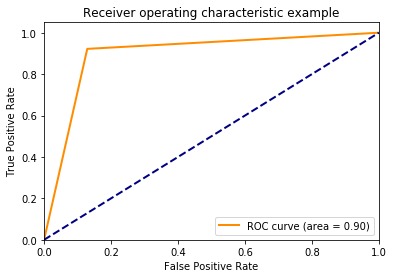

In [23]:
import matplotlib.pyplot as plt
roc_auc = metrics.auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()